In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from skimage.color import gray2rgb
from tqdm import tqdm
import tifffile
from PIL import Image
import json
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import seaborn as sns
from sklearn.mixture import GaussianMixture
from anndata import AnnData


In [31]:
df_gloms = ad_pt_slide2.obs
df_gloms

Disease  dpt_pseudotime  Pseudotime Slide_ID  \
polygon_flags                                                             
0_0011186_ANCA_X3_slide2      ANCA        0.557568    0.557568  0011186   
0_0011186_ANCA_X4_slide2      ANCA        0.416435    0.416435  0011186   
0_0011186_ANCA_X6_slide2      ANCA        0.417834    0.417834  0011186   
0_0011186_Cntrl_X1_slide2  Control        0.000000    0.000000  0011186   
0_0011186_Cntrl_X2_slide2  Control        0.106783    0.106783  0011186   
...                            ...             ...         ...      ...   
7_0011186_Cntrl_X2_slide2  Control        0.239479    0.239479  0011186   
8_0011186_Cntrl_X1_slide2  Control        0.075411    0.075411  0011186   
8_0011186_Cntrl_X2_slide2  Control        0.283191    0.283191  0011186   
9_0011186_Cntrl_X1_slide2  Control        0.093601    0.093601  0011186   
9_0011186_Cntrl_X2_slide2  Control        0.268351    0.268351  0011186   

                           Ki67_prot  CD44_prot      TGFB      PDGF  
polygon_flags                                                        
0_0011186_ANCA_X3_slide2    3.169925  13.225659  0.039008  0.009414  
0_0011186_ANCA_X4_slide2    0.000000   1.000000  0.020137  0.072077  
0_0011186_ANCA_X6_slide2   12.573411  14.814282  0.004359  0.047995  
0_0011186_Cntrl_X1_slide2   0.000000   0.000000  0.001060  0.038192  
0_0011186_Cntrl_X2_slide2   0.000000   1.000000  0.033462  0.053815  
...                              ...        ...       ...       ...  
7_0011186_Cntrl_X2_slide2   3.000000   0.000000  0.005284  0.021387  
8_0011186_Cntrl_X1_slide2  10.202124  13.682007  0.006020  0.054870  
8_0011186_Cntrl_X2_slide2   0.000000   0.000000  0.005646  0.011361  
9_0011186_Cntrl_X1_slide2   8.857981   9.529431  0.001920  0.037695  
9_0011186_Cntrl_X2_slide2   0.000000   0.000000  0.015066  0.014400  

[90 rows x 8 columns]

In [33]:
df_all = adata.obs

In [34]:
adata.obs.columns

Index(['x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation',
       'area', 'avg_confidence', 'avg_assignment_confidence',
       'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area',
       'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob',
       'Slide_ID', 'sample', 'Disease', 'cell_name', 'Ki67', 'batch',
       'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no',
       'CD44_prot', 'Ki67_prot', 'glom_ID', 'polygon_flags', 'is_in_polygon',
       'is_in_glom', 'is_in_periglom'],
      dtype='object')

In [17]:
ad_all =  sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")
ad_protein =  sc.read_h5ad("/data/projects/Behnam/xenium-cgn/notebooks/03_image_registration/data_level_1/adata_slide2_PECinPoly_Ki67_CD44_noX1andX8.h5ad")
ad_gloms =  sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/pseudotime.h5ad")

In [18]:
df_all = ad_all.obs
df_prot = ad_protein.obs
df_gloms = ad_gloms.obs

In [19]:
# Now we need to merge these: df_all, df_prot, df_gloms

In [20]:
df_merge = pd.merge(df_all, df_gloms, left_on='polygon_flags', right_index=True, suffixes=('', '_ptime'))
df_merge.index = ['-'.join(i.split('-')[0:2]) for i in df_merge.index]
df_prot.index = ['-'.join(i.split('-')[0:2]) for i in df_prot.index]
df_merge_final = pd.merge(df_merge, df_prot, right_index=True, left_index=True, how = 'inner', suffixes=('', '_protein'))

In [21]:
df_merge_final.shape, df_prot.shape

((737, 70), (737, 27))

In [22]:
df_merge_final_plot = df_merge_final[['x', 'y', 'celltype_l1', 'Pseudotime', 'Ki67_protein', 'CD44', 'polygon_flags']].copy()
df_merge_final_plot

x             y celltype_l1  Pseudotime  \
cell_CR9fbacb852-117027   731.995284  17253.393345         PEC    0.106783   
cell_CR9fbacb852-117054   736.203982  17252.430278         PEC    0.106783   
cell_CR9fbacb852-117111   742.897142  17254.947588         PEC    0.106783   
cell_CR9fbacb852-117175   754.476935  17258.092233         PEC    0.106783   
cell_CR9fbacb852-117395   685.508616  17373.274537         PEC    0.106783   
...                              ...           ...         ...         ...   
cell_CR9fbacb852-42204   7411.122152   2745.057792         PEC    0.429149   
cell_CR9fbacb852-42217   7418.741944   2738.735971         PEC    0.429149   
cell_CR9fbacb852-43218   7491.903544   2741.394959         PEC    0.429149   
cell_CR9fbacb852-301474  7306.837825   2809.454295         PEC    0.429149   
cell_CR9fbacb852-338169  7352.698877   2616.240542         PEC    0.429149   

                         Ki67_protein  CD44              polygon_flags  
cell_CR9fbacb852-117027             0     0  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117054             0     0  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117111             0     0  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117175             0     7  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117395             0     5  0_0011186_Cntrl_X2_slide2  
...                               ...   ...                        ...  
cell_CR9fbacb852-42204              1    13    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-42217              0    37    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-43218              2     3    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-301474             0    15    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-338169             0    13    5_0011186_SLE_X7_slide2  

[737 rows x 7 columns]

In [48]:
tokeep = [False if len(i.split(',')) > 1 else True for i in df_merge_final_plot['polygon_flags']]
df_merge_final_plot = df_merge_final_plot.loc[tokeep]
df_merge_final_plot

x             y celltype_l1  Pseudotime  \
cell_CR9fbacb852-117027   731.995284  17253.393345         PEC    0.106783   
cell_CR9fbacb852-117054   736.203982  17252.430278         PEC    0.106783   
cell_CR9fbacb852-117111   742.897142  17254.947588         PEC    0.106783   
cell_CR9fbacb852-117175   754.476935  17258.092233         PEC    0.106783   
cell_CR9fbacb852-117395   685.508616  17373.274537         PEC    0.106783   
...                              ...           ...         ...         ...   
cell_CR9fbacb852-42204   7411.122152   2745.057792         PEC    0.429149   
cell_CR9fbacb852-42217   7418.741944   2738.735971         PEC    0.429149   
cell_CR9fbacb852-43218   7491.903544   2741.394959         PEC    0.429149   
cell_CR9fbacb852-301474  7306.837825   2809.454295         PEC    0.429149   
cell_CR9fbacb852-338169  7352.698877   2616.240542         PEC    0.429149   

                         Ki67_protein  CD44              polygon_flags  
cell_CR9fbacb852-117027             0     0  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117054             0     0  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117111             0     0  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117175             0     7  0_0011186_Cntrl_X2_slide2  
cell_CR9fbacb852-117395             0     5  0_0011186_Cntrl_X2_slide2  
...                               ...   ...                        ...  
cell_CR9fbacb852-42204              1    13    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-42217              0    37    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-43218              2     3    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-301474             0    15    5_0011186_SLE_X7_slide2  
cell_CR9fbacb852-338169             0    13    5_0011186_SLE_X7_slide2  

[718 rows x 7 columns]

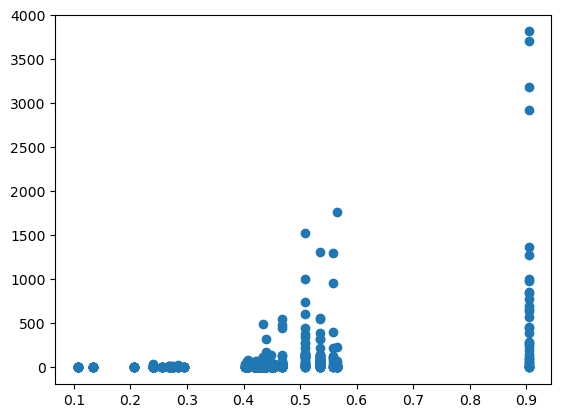

In [49]:
plt.scatter(df_merge_final_plot['Pseudotime'],df_merge_final_plot['CD44'])

Text(0.5, 1.0, 'CD44 per PECs in glom')

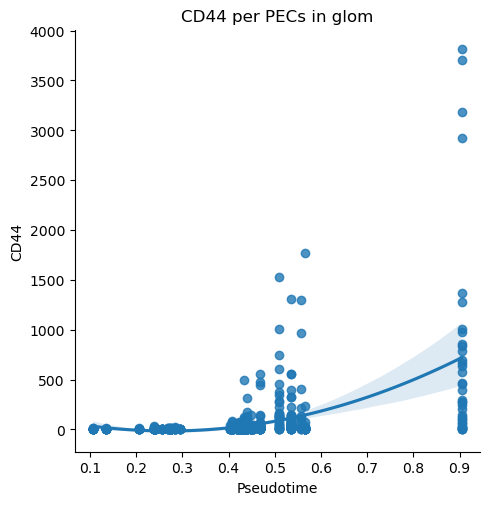

In [64]:
ax = sns.lmplot(data=df_merge_final_plot,x="Pseudotime",y="CD44", order=2, scatter=True, palette="colorblind")
plt.title("CD44 per PECs in glom")
#plt.savefig("glom_score_lines_with_ci_tgf_all_targets.pdf", bbox_inches="tight")

Text(0.5, 1.0, 'Ki67 per PECs in glom')

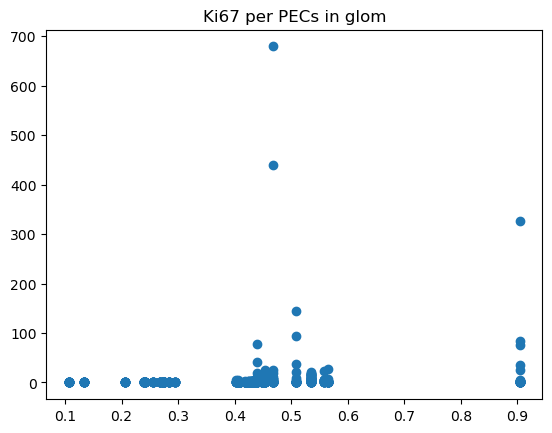

In [65]:
plt.scatter(df_merge_final_plot['Pseudotime'], df_merge_final_plot['Ki67_protein'])
plt.title("Ki67 per PECs in glom")
#plt.ylim(0,20)

Text(0.5, 1.0, 'Ki67 per PECs in glom')

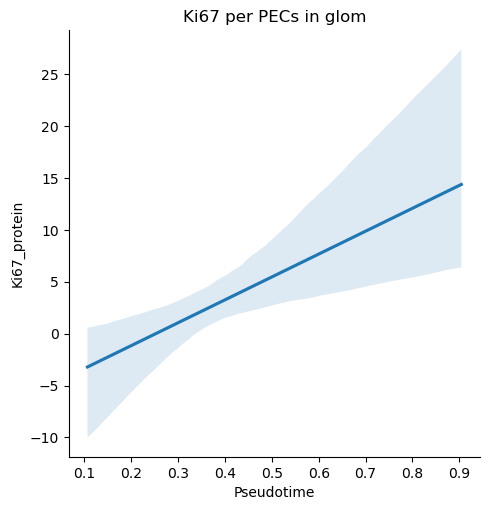

In [66]:
ax = sns.lmplot(data=df_merge_final_plot,x="Pseudotime",y="Ki67_protein", order=1, scatter=False, palette="colorblind")
plt.title("Ki67 per PECs in glom")

In [2]:
# grouped = df_merge_final_plot.groupby('polygon_flags')[['Ki67_protein', 'CD44']].sum()

In [67]:
grouped = df_merge_final_plot.groupby('polygon_flags', as_index=False).agg({
    'Ki67_protein': 'mean',
    'CD44': 'mean',
    'Pseudotime': 'first'
})

# grouped.sort_values("Pseudotime")

Text(0.5, 1.0, 'average CD44+ PECs per gloms')

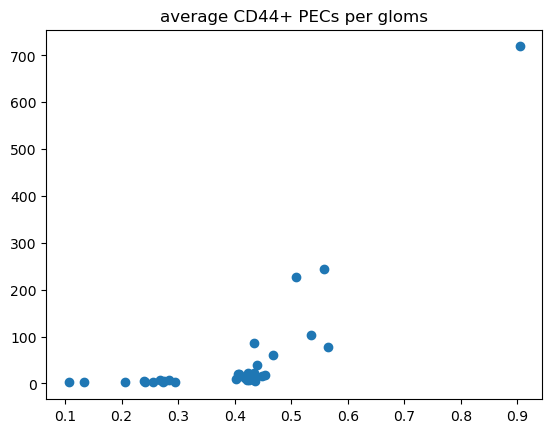

In [68]:
plt.scatter(grouped['Pseudotime'], grouped['CD44'])
plt.title("average CD44+ PECs per gloms")

Text(0.5, 1.0, 'average CD44+ PECs per gloms')

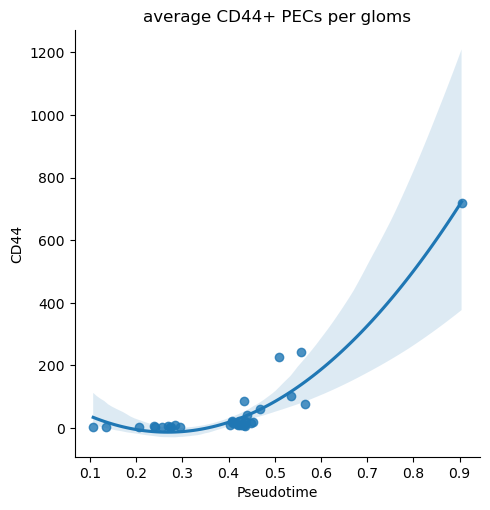

In [69]:
ax = sns.lmplot(data=grouped,x="Pseudotime",y="CD44", order=2, scatter=True, palette="colorblind")
plt.title("average CD44+ PECs per gloms")

Text(0.5, 1.0, 'average Ki67+ PECs per gloms')

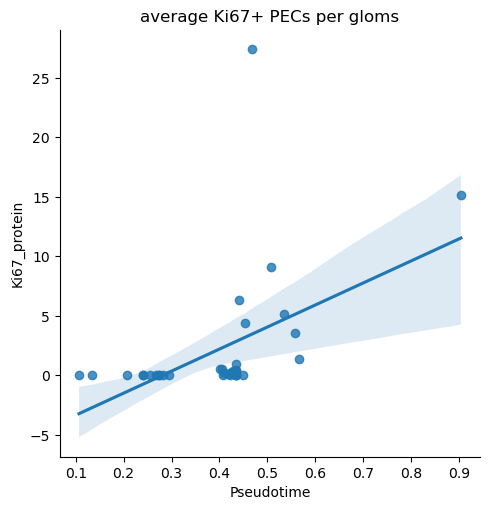

In [70]:
ax = sns.lmplot(data=grouped,x="Pseudotime",y="Ki67_protein", order=1, scatter=True, palette="colorblind")
plt.title("average Ki67+ PECs per gloms")